# Олимпиада по Кибериммунной разработке 

## Создание конструктивно защищённой автономной роботизированной платформы бурения тоннелей 

## Модуль 3

## О документе

Модуль 3 для олимпиады по кибериммунной разработке

Перенесите реализованный код сущности ControlSystem из модуля 2 в данный модуль

Используя наработки с предыдущих двух модулей, пройдите полный маршрут задания АРПБТ с применением киберпрепятствия, для этого необходимо внести изменения в нашу архитектуру

На рисунке 1 представлена архитектура решения с применением модуля обеспечивающим исполнение целей безопасности.

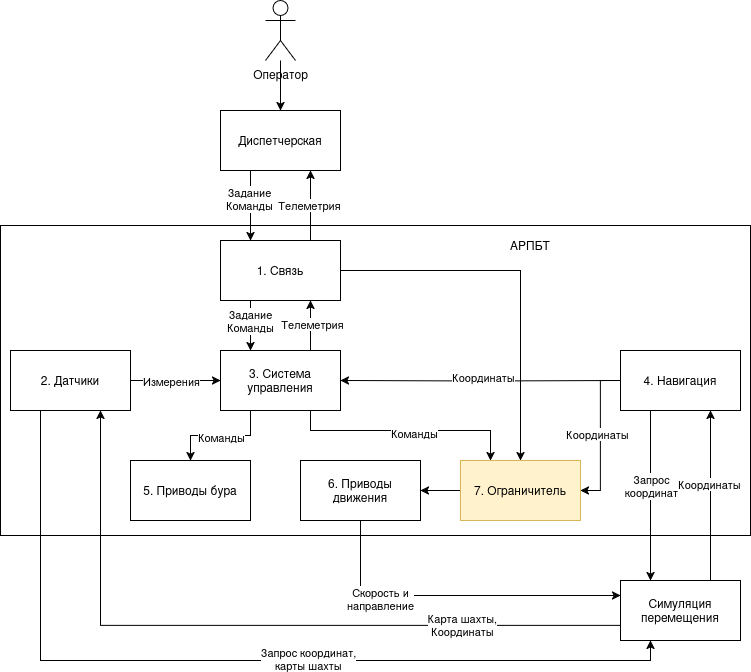

Рисунок 1. Архитектура АРПБТ с применением Ограничителя

## ЦПБ

Устойчивость кибериммунных систем к атакам выражается в том, что поставленные заказчиком цели безопасности (ЦБ) не нарушаются даже в условиях кибератак (снаружи и изнутри).

#### Цели безопасности

1. При любых обстоятельствах АРПБТ осуществляет перемещения в пределах заданных ограничений
2. При любых обстоятельствах АРПБТ бурит тоннель только в авторизованном пункте назначения
3. При любых обстоятельствах АРПБТ выполняет только аутентичный маршрут ***(Опционально)***

#### Предположения безопасности

При этом заказчик согласовал с разработчиками следующие предположения безопасности (ПБ) - утверждения о смежных системах, которые снимают с разработчиков часть задач для обеспечения целей безопасности:

- При любых обстоятельствах только авторизованный персонал имеет физический доступ к критическим узлам АРПБТ
- При любых обстоятельствах только аутентичные и авторизованные операторы имеют доступ к диспетчерской
- Аутентичные и авторизованные операторы обладают необходимой квалификацией и являются благонадёжными (т.е. не пытаются намеренно причинить ущерб системе или третьим лицам, используя доступ к АРПБТ)

Для продолжения перенести код реализованной сущности ControlSystem из модуля 2

Общий пул очереди

In [ ]:
from multiprocessing import Queue

events_queue = Queue()

Классы Event

In [ ]:
from dataclasses import dataclass


# формат управляющих команд
@dataclass
class ControlEvent:
    operation: str


@dataclass
class Event:
    source: str  # отправитель
    destination: str  # получатель
    operation: str  # чего хочет (запрашиваемое действие)
    parameters: str  # с какими параметрами

Создадим общего менеджера очереди

In [ ]:
from multiprocessing import Queue, Process
from multiprocessing.queues import Empty
from time import sleep


# Класс
class QueueManage(Process):

    def __init__(self, events_q: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self._events_q = events_q  # очередь событий входящие сообщения
        self._control_q = (
            Queue()
        )  # очередь управляющих команд (например, для остановки монитора)
        self._entity_queues = {}  # словарь очередей известных монитору сущностей
        self._force_quit = False  # флаг завершения работы монитора

    # регистрация очереди новой сущности
    def add_entity_queue(self, entity_id: str, queue: Queue):
        # print(f"[ИНФО] регистрируем сущность {entity_id}")
        self._entity_queues[entity_id] = queue

    def _proceed(self, event):
        # print(f'[ИНФО] отправляем запрос {event}')
        try:
            # найдём очередь получателя события
            dst_q: Queue = self._entity_queues[event.destination]
            # и положим запрос в эту очередь
            dst_q.put(event)
        except Exception as e:
            # например, запрос пришёл от или для неизвестной сущности
            print(f"[ИНФО] ошибка выполнения запроса {e}")

    # основной код работы монитора безопасности
    def run(self):
        # print('[ИНФО] старт')

        # в цикле проверяет наличие новых событий,
        # выход из цикла по флагу _force_quit
        while self._force_quit is False:
            event = None
            try:
                # ожидание сделано неблокирующим,
                # чтобы можно было завершить работу монитора,
                # не дожидаясь нового сообщения
                event = self._events_q.get_nowait()
                self._proceed(event)
            except Empty:
                # сюда попадаем, если новых сообщений ещё нет,
                # в таком случае немного подождём
                sleep(0.5)
            except Exception as e:
                # что-то пошло не так, выведем сообщение об ошибке
                print(f"[ИНФО] ошибка обработки {e}, {event}")
            self._check_control_q()
        # print('[ИНФО] завершение работы')

    # запрос на остановку для завершения работы
    # может вызываться вне процесса
    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    # проверка наличия новых управляющих команд
    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            #  print(f"[ИНФО] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность ControlSystem

#### Сущность Sensors

In [ ]:
import requests
from src.sensors_calc import calculate_obstacle_distances
from multiprocessing import Queue, Process


class Sensors(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False
        self._config = None

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")

        response = requests.get(
            "http://127.0.0.1:5000/config"
        )  # URL для получения конфигурации карты шахты
        response.raise_for_status()
        self._config = response.json()

        while self._force_quit is False:
            try:
                sleep(0.2)
                response = requests.get(
                    "http://127.0.0.1:5000/position"
                )  # URL для получения текущих координат
                response.raise_for_status()
                coordinates = response.json()

                obstacle_distances = calculate_obstacle_distances(
                    coordinates["x"],
                    coordinates["y"],
                    self._config["obstacles"],
                    (self._config["field_width"], self._config["field_height"]),
                    10,
                )

                # print(f"[{self.__class__.__name__}]Текущие расстояния до препятствия: {obstacle_distances}")

                event = Event(
                    source=self.__class__.__name__,
                    destination="ControlSystem",
                    operation="get_directions",
                    parameters=obstacle_distances,
                )
                self.events_queue.put(event)
                self._check_control_q()
            except requests.exceptions.RequestException as e:
                print(f"[{self.__class__.__name__}]Ошибка запроса: {e}")
                self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность Communication

In [ ]:
from multiprocessing import Queue, Process

CYBER_OBSTACLE = False


class Communication(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        print(f"[{self.__class__.__name__}] отправляем новое задание")

        # Отметили контрольную точку в симуляторе и скопировали её
        task = 
        # Убрать комментарии в случае выполнения ЦБ 3
        #if CYBER_OBSTACLE: 
        #    task.pop(2)
        #   task.append()

        event = Event(
            source=self.__class__.__name__,
            destination="ControlSystem",
            operation="new_task",
            parameters=task,
        )

        self.events_queue.put(event)


        event = Event(
            source=self.__class__.__name__,
            destination="SecurityModule",
            operation="new_task",
            parameters=task,
        )

        self.events_queue.put(event)
        print(f"[{self.__class__.__name__}] завершение работы")

#### Сущность Navigation

In [ ]:
from multiprocessing import Queue, Process


class Navigation(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        while self._force_quit is False:
            try:
                sleep(0.2)
                response = requests.get(
                    "http://127.0.0.1:5000/position"
                )  # URL для получения текущих координат
                response.raise_for_status()
                coordinates = response.json()
                # print(f"[{self.__class__.__name__}]Текущая позиция: X={coordinates['x']}, Y={coordinates['y']}")
                event = Event(
                    source=self.__class__.__name__,
                    destination="ControlSystem",
                    operation="get_coordinates",
                    parameters=coordinates,
                )
                self.events_queue.put(event)
                
                
                event = Event(
                    source=self.__class__.__name__,
                    destination="SecurityModule",
                    operation="get_coordinates",
                    parameters=coordinates,
                )
                self.events_queue.put(event)

                self._check_control_q()
            except requests.exceptions.RequestException as e:
                print(f"[{self.__class__.__name__}]Ошибка запроса: {e}")
                self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность Servos

In [ ]:
from multiprocessing import Queue, Process


class Servos(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        while self._force_quit is False:
            self._check_event_queue()
            self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_event_queue(self):
        event = None
        try:
            event: Event = self._own_queue.get_nowait()
            if event.operation == "set_velocity":
                # print(f"[{self.__class__.__name__}] {event.source} прислал новые параметры управления {event.parameters}")
                try:
                    data = event.parameters
                    response = requests.post(
                        "http://127.0.0.1:5000/set_velocity", json=data
                    )  # URL для обновления параметров скорости и направления движения
                    response.raise_for_status()
                except requests.exceptions.RequestException as e:
                    print(f"[{self.__class__.__name__}]Ошибка запроса: {e}")
        except Empty:
            sleep(0.1)
        except Exception as e:
            # что-то пошло не так, выведем сообщение об ошибке
            print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность Drill

In [ ]:
from multiprocessing import Queue, Process


class Drill(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")

        while self._force_quit is False:
            self._check_event_queue()
            self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_event_queue(self):
        event = None
        try:
            event: Event = self._own_queue.get_nowait()
            if event.operation == "drilling":
                print(f"[{self.__class__.__name__}] бурим тоннель")
        except Empty:
            sleep(0.1)
        except Exception as e:
            # что-то пошло не так, выведем сообщение об ошибке
            print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

Теперь перейдём к новому модулю 

#### Сущность SecurityMode

In [ ]:
from multiprocessing import Queue, Process
import math 

class SecurityModule(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = (
            Queue()
        )  # очередь управляющих команд (например, для остановки)
        self._force_quit = False
        self._targets_points = []  # Точки маршрута
        self._current_coordinates = None  # Текущие координаты АРПБТ
        
    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q


    def check_mission(self):
            data = {}
            print(f'[{self.__class__.__name__}] отправляем сигналы управления приводами движения {data}')

            event = Event(
                source=self.__class__.__name__,
                destination="Servos",
                operation="set_velocity",
                parameters=data,
            )
            self.events_queue.put(event)

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        while self._force_quit is False:
            sleep(0.02)
            self._check_event_queue()
            self._check_control_q()
            self.check_mission()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

    def _check_event_queue(self):
        event = None
        try:
            event: Event = self._own_queue.get_nowait()

            if event.operation == "new_task":
                print(
                    f"[{self.__class__.__name__}] {event.source} прислал новое задание {event.parameters}"
                )
                print(f"[{self.__class__.__name__}] новое задание: {event.parameters}!")
                self._targets_points = event.parameters

            if event.operation == "get_coordinates":
                # print(f"[{self.__class__.__name__}] текущая позиция АРПБТ {event.parameters}")
                self._current_coordinates = event.parameters
            
            if event.operation == "set_velocity":
                print(f"[{self.__class__.__name__}] данные от Control System {event.parameters}")
                self._current_speed = event.parameters["speed"]
                self._current_direction = event.parameters["direction"]


        except Empty:
            sleep(0.05)
        except Exception as e:
            # что-то пошло не так, выведем сообщение об ошибке
            print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")

Прежде чем мы начнём внедрять механизмы безопасности, посмотрим, что произойдёт с нашей машинкой, если бортовые системы начнут вести себя не так, как мы ожидаем.

Для того чтобы включить киберпрепятствия измените значение **CYBER_OBSTACLE** в src/control_systems_calc.py на **True**

```python
CYBER_OBSTACLE = True
```

Запустите симуляцию и внимательно смотрите за движением АРПБТ.

In [ ]:
queue_manager = QueueManage(events_queue)
communication = Communication(events_queue)
control_system = ControlSystem(events_queue)
navigation = Navigation(events_queue)
servos = Servos(events_queue)
sensors = Sensors(events_queue)
drill = Drill(events_queue)
queue_manager.add_entity_queue(
    communication.__class__.__name__, communication.entity_queue()
)
queue_manager.add_entity_queue(
    control_system.__class__.__name__, control_system.entity_queue()
)
queue_manager.add_entity_queue(navigation.__class__.__name__, navigation.entity_queue())
queue_manager.add_entity_queue(servos.__class__.__name__, servos.entity_queue())
queue_manager.add_entity_queue(sensors.__class__.__name__, sensors.entity_queue())
queue_manager.add_entity_queue(drill.__class__.__name__, drill.entity_queue())
queue_manager.start()
communication.start()
control_system.start()
navigation.start()
sensors.start()
servos.start()
drill.start()
sleep(100)
queue_manager.stop()
communication.join()
control_system.stop()
navigation.stop()
sensors.stop()
servos.stop()
drill.stop()

Итак, в отличие от, надеемся, успешного завершения маршрута в модуле 2, сейчас ваша АРПБТ ведёт себя совсем иначе. Например, она внезапно едет в совершенно другую сторону. 
И это ещё не всё, что может пойти не так..

В этой реализации не очень много кода, теоретически, вы можете его весь изучить и устранить "незадокументированные возможности", однако в реальных системах кода гораздо больше. Например, кодовая база проекта с открытым исходным кодом ArduPilot, реализующего в том числе логику автопилота, составляет примерно миллион строк. 

Сколько времени вам понадобится, чтобы изучить и протестировать миллион строк кода? А ведь придётся проводить анализ и каждого обновления.. При этом неприятности могут быть хорошо спрятанными и на первый взгляд безобидными, вряд ли злоумышленники облегчат задачу и назовут свои изменения, например, "hacking_the_system" или "allowing_secret_remote_access". Вредоносный код может выглядеть совершенно безобидно или маскироваться под программный дефект.

Поэтому тщательный анализ потребует большого количества ресурсов (человеческих, вычислительных, временных), что стоит дорого. 

Логичным выходом является выделение критичных для целей безопасности проверок в отдельный блок, который протестировать должно быть гораздо проще.

1. Реализуйте данный модуль, код которого бы соблюдал ЦБ 1

2. Внесите необходимые изменения в архитектуру, чтобы могла выполняться ЦБ 2. Опишите подробно внесенные изменения в код и в архитектуру.

3. ***ЦБ3 Опциональная задача для реализации***. Для того чтобы корректно ее выполнить необходимо изменить код многих сущностей(Связь, Система управления, Ограничитель). Если остается время и силы, только тогда переходить к ее реализации. Опишите подробно внесенные изменения в код и в архитектуру.

Инициализация модулей

In [ ]:
queue_manager = QueueManage(events_queue)
communication = Communication(events_queue)
control_system = ControlSystem(events_queue)
navigation = Navigation(events_queue)
servos = Servos(events_queue)
sensors = Sensors(events_queue)
drill = Drill(events_queue)
security = SecurityModule(events_queue)

Добавляем в общую очередь все реализованные сущности, можно сказать регистрируем их в менеджере Очереди

In [ ]:
queue_manager.add_entity_queue(
    communication.__class__.__name__, communication.entity_queue()
)
queue_manager.add_entity_queue(
    control_system.__class__.__name__, control_system.entity_queue()
)
queue_manager.add_entity_queue(navigation.__class__.__name__, navigation.entity_queue())
queue_manager.add_entity_queue(servos.__class__.__name__, servos.entity_queue())
queue_manager.add_entity_queue(sensors.__class__.__name__, sensors.entity_queue())
queue_manager.add_entity_queue(drill.__class__.__name__, drill.entity_queue())
queue_manager.add_entity_queue(security.__class__.__name__, security.entity_queue())

Запуск симуляции

In [ ]:
queue_manager.start()
communication.start()
control_system.start()
navigation.start()
sensors.start()
servos.start()
drill.start()
security.start()
sleep(60)
queue_manager.stop()
communication.join()
control_system.stop()
navigation.stop()
sensors.stop()
servos.stop()
drill.stop()
security.stop()